In [2]:
import torch
import numpy
import pennylane as qml
import pennylane.numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
def Cliff2():
    """
    Random 2-qubit Clifford circuit.

    Arguments:
        -nodes (np.ndarray): 
    
    Returns:
        -null
    """
    
    weights = np.random.randint(2, size=(2, 10))
    
    return qml.matrix(qml.RandomLayers(weights=weights,wires=[0,1])).numpy()

In [4]:
def RandomLayers(N_QUBITS, DEPTH):
    """
    Generates brick wall pattern of random 2 qubit Clifford gates

    Arguments:
        -N_QUBITS (int): Number of qubits
        -DEPTH (int): Depth of the circuit

    Returns:
        -random_layers (np.ndarray): Array of 4x4 unitaries (N_QUBITS, DEPTH, 4, 4)
    
    """

    random_layers = []
    for t in range(DEPTH):
        layer = []
        for x in range(0,N_QUBITS,2):
                layer.append(Cliff2())
        random_layers.append(layer)

    return random_layers


In [5]:
N_QUBITS = 2*3
DEPTH = 2

# random_layers = []
# # for t in range(DEPTH):
# #         layer = []
# #         for x in range(0,N_QUBITS,2):
# #                 layer.append(Cliff2())
# #         random_layers.append(layer)

random_layers = RandomLayers(N_QUBITS,DEPTH)

dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def circuit(theta):
    """
    Quantum circuit with random entangling Clifford layers and disentangling layers.
    
    Arguments:
        -theta (np.ndarray): Binary matrix representing the positions of projections. (N_QUBITS, DEPTH)
    
    Returns:
        -Average Von Neumann entropy (float32): Average of 2-qubit Von Neumann entropies over all neighbors.
    """

    theta = theta.T
    DEPTH,N_QUBITS = np.shape(theta)

    for t in range(DEPTH):
        layer = random_layers[t]
        if t%2==0:
            for x in range(0,N_QUBITS,2):
                brick = layer[int(x/2)]
                qml.QubitUnitary(brick,wires=[x,x+1])
        elif t%2==1:
            for x in range(1,N_QUBITS-2,2):
                brick = layer[int((x-1)/2)]
                qml.QubitUnitary(brick,wires=[x,x+1])
            brick = layer[-1]
            qml.QubitUnitary(brick,wires=[N_QUBITS-1,0])
            
        projections = theta[t]
        for x in range(N_QUBITS):
            if projections[x]==1:
                qml.Projector(state=[0],wires=[x])
            
    entropies = []
    for x in range(N_QUBITS-1):
        entropies.append(qml.vn_entropy(wires=[x,x+1]))
    entropies.append(qml.vn_entropy(wires=[N_QUBITS-1,0]))
        
    return entropies

In [6]:
random_layers[0][1]

array([[ 0.15141415+0.19481533j,  0.19353317-0.38312858j,
        -0.64050087+0.45553265j,  0.09895008+0.35684125j],
       [-0.01248463-0.51953317j,  0.68849954-0.10380728j,
         0.01640907+0.22589722j, -0.07730943-0.43341238j],
       [-0.80916998-0.06659277j, -0.08060534+0.29864742j,
        -0.23185642+0.22036595j,  0.3735698 -0.05699914j],
       [-0.05936503+0.07959464j,  0.404201  -0.26811172j,
         0.32985455-0.34616075j,  0.64633565+0.32938896j]])

In [7]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
print(circuit(theta))
print(type(circuit(theta)))
drawer = qml.draw(circuit)

print(drawer(theta))

[2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 3.4251661569637098e-15, 2.220446049250313e-16]
<class 'list'>
0: ─╭U(M0)──|0⟩⟨0|────────╭U(M5)──|0⟩⟨0|─┤ ╭vnentropy                                            
1: ─╰U(M0)──|0⟩⟨0|─╭U(M3)─│───────|0⟩⟨0|─┤ ╰vnentropy ╭vnentropy                                 
2: ─╭U(M1)─────────╰U(M3)─│───────|0⟩⟨0|─┤            ╰vnentropy ╭vnentropy                      
3: ─╰U(M1)─────────╭U(M4)─│───────|0⟩⟨0|─┤                       ╰vnentropy ╭vnentropy           
4: ─╭U(M2)──|0⟩⟨0|─╰U(M4)─│──────────────┤                                  ╰vnentropy ╭vnentropy
5: ─╰U(M2)──|0⟩⟨0|────────╰U(M5)──|0⟩⟨0|─┤                                             ╰vnentropy

  ╭vnentropy
  │         
  │         
  │         
  │         
  ╰vnentropy

M0 = 
[[-0.25459171+0.25502041j -0.16069863-0.15223301j -0.55933333+0.65408534j
   0.0043502 -0.28363425j]
 [-0.0043502 +0.28363425j  0.76570015-0.45858995j  0.16069863+0.152233

In [41]:
def RandomFlip(theta,K):
    """
    Randomly flip K entries of a binary matrix theta.

    Arguments:
        -theta (np.ndarray):
        -K (int): 

    Returns:
        -flipped (np.ndarray):

    """
    
    x,y = np.shape(theta)
    N = int(x*y)
    arr = np.array([0] * (N-K) + [1] * K)
    np.random.shuffle(arr)
    arr = arr.reshape((x,y))

    flipped = (theta + arr) % 2
    
    return flipped

In [46]:
class Disentangler(gym.Env):
    """
    Reinforcement learning environment for the disentangler.

    """
    
    def __init__(self):
        self.action_space = gym.spaces.Discrete(10)
        self.observation_space = []
        self.state = np.zeros((N_QUBITS,DEPTH))
        self.moves = 20

    def step(self, action):
        self.state = RandomFlip(self.state, action)
        self.moves += -1

        entropies = circuit(self.state)
        entropy = sum(entropies)/len(entropies)

        trivial1 = (sum(self.state[:,-1]) == len(self.state[:,-1]))
        trivial2 = (sum(self.state[:,-1]) == len(self.state[:,-1]) - 1)
        trivial = (trivial1 or trivial2)

        if self.moves <= 0:
            reward = 0
            done = True
        else:
            reward = 0
            done = False
        
        if entropy < 1e-20:
            reward = 100
            done = True

        if trivial:
            reward = -100
            done = True

        info = {}
        
        return self.state, reward, done, info
    
    def reset(self):
        self.state = np.zeros((N_QUBITS,DEPTH))
        self.moves = 20

        return self.state

In [47]:
env = Disentangler()

In [48]:
# test run

episodes = 2000
measurements = []
scores = []
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
    
    measurements.append(n_state)
    scores.append(score)
    
    print('Episode:{} Score:{}'.format(episode, score))


Episode:1 Score:0
Episode:2 Score:0
Episode:3 Score:-100
Episode:4 Score:-100
Episode:5 Score:-100
Episode:6 Score:-100
Episode:7 Score:100
Episode:8 Score:-100
Episode:9 Score:-100
Episode:10 Score:0
Episode:11 Score:100
Episode:12 Score:-100
Episode:13 Score:-100
Episode:14 Score:-100
Episode:15 Score:-100
Episode:16 Score:0
Episode:17 Score:-100
Episode:18 Score:0
Episode:19 Score:-100
Episode:20 Score:-100
Episode:21 Score:-100
Episode:22 Score:-100
Episode:23 Score:100
Episode:24 Score:-100
Episode:25 Score:-100
Episode:26 Score:0
Episode:27 Score:-100
Episode:28 Score:-100
Episode:29 Score:-100
Episode:30 Score:-100
Episode:31 Score:-100
Episode:32 Score:0
Episode:33 Score:-100
Episode:34 Score:-100
Episode:35 Score:0
Episode:36 Score:-100
Episode:37 Score:0
Episode:38 Score:-100
Episode:39 Score:-100
Episode:40 Score:0
Episode:41 Score:-100
Episode:42 Score:-100
Episode:43 Score:-100
Episode:44 Score:-100
Episode:45 Score:-100
Episode:46 Score:0
Episode:47 Score:100
Episode:48 S

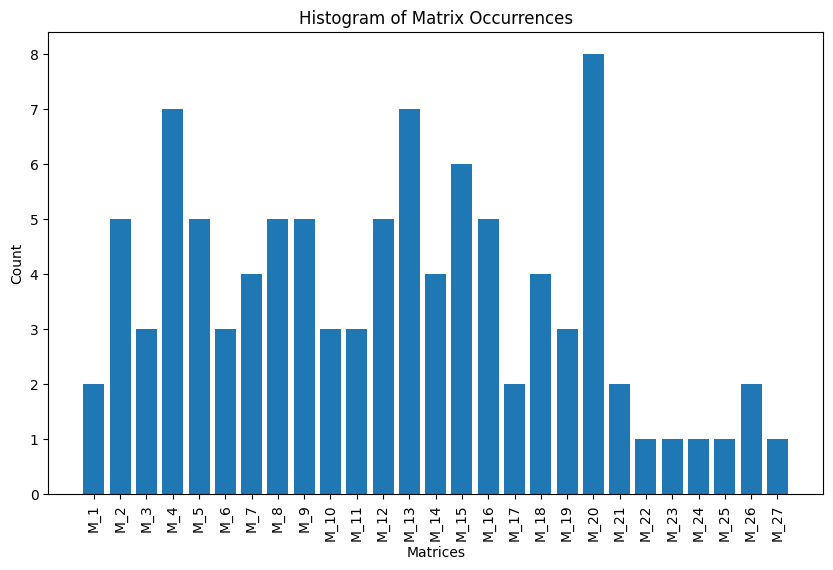

27


In [55]:
# histogram for the efficient disentanglers
disentanglers = []
for i in range(len(scores)):
    if scores[i] == 100:
        disentanglers.append(measurements[i])

hashable_matrices = [tuple(map(tuple, matrix)) for matrix in disentanglers]

matrix_counts = Counter(hashable_matrices)

labels, counts = zip(*matrix_counts.items())

labels = [np.array(label) for label in labels]

plt.figure(figsize=(10,6))
plt.bar(range(len(counts)), counts, tick_label=["M_"+str(i+1) for i in range(len(labels))])
plt.xlabel('Matrices')
plt.ylabel('Count')
plt.title('Histogram of Matrix Occurrences')
plt.xticks(rotation=90)
plt.show()
print(len(labels))